In [24]:
import numpy as np
import porepy as pp
from matplotlib import pyplot as plt
from frac_poromech import make_model

model = make_model()
model.prepare_simulation()
pp.run_time_dependent_model(model, {"prepare_simulation": False, "progressbars": True})

time loop:   0%|          | 0/100 [00:00<?, ?it/s]

Newton loop:   0%|          | 0/10 [00:00<?, ?it/s]

Newton loop:   0%|          | 0/10 [00:00<?, ?it/s]

Newton loop:   0%|          | 0/10 [00:00<?, ?it/s]

Newton loop:   0%|          | 0/10 [00:00<?, ?it/s]

Newton loop:   0%|          | 0/10 [00:00<?, ?it/s]

Newton loop:   0%|          | 0/10 [00:00<?, ?it/s]

Newton loop:   0%|          | 0/10 [00:00<?, ?it/s]

Newton loop:   0%|          | 0/10 [00:00<?, ?it/s]

Newton loop:   0%|          | 0/10 [00:00<?, ?it/s]

Newton loop:   0%|          | 0/10 [00:00<?, ?it/s]

Newton loop:   0%|          | 0/10 [00:00<?, ?it/s]

Newton loop:   0%|          | 0/10 [00:00<?, ?it/s]

Newton loop:   0%|          | 0/10 [00:00<?, ?it/s]

Newton loop:   0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
model.displacement(model.mdg.subdomains(dim=2)).value(model.equation_system).max()

0.1172620506520971

In [26]:
model.interface_displacement(model.mdg.interfaces()).value(model.equation_system)

array([0.00197621, 0.00131602, 0.00316075, 0.00184021, 0.00439932,
       0.00248134, 0.0057645 , 0.00320061, 0.00728543, 0.00397016,
       0.00896925, 0.00475423, 0.01089089, 0.00553668, 0.01304165,
       0.0062721 , 0.01549715, 0.00690023, 0.01825386, 0.00734116,
       0.00141965, 0.00245606, 0.00191614, 0.00388817, 0.00248079,
       0.00516246, 0.00320469, 0.00626105, 0.00415443, 0.00712162,
       0.00541242, 0.00767204, 0.00714382, 0.00788102, 0.00944097,
       0.00774941, 0.01242582, 0.00731938, 0.01626167, 0.00685308])

In [27]:
model.contact_traction(model.mdg.subdomains(dim=1)).value(model.equation_system)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

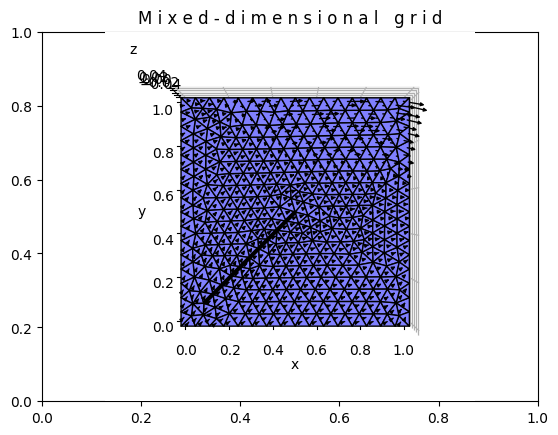

In [28]:
pp.plot_grid(
    model.mdg,
    # cell_value=model.pressure_variable,
    vector_value=model.displacement_variable,
    plot_2d=False,
    fracturewidth_1d=3,
    rgb=[0.5, 0.5, 1],
)

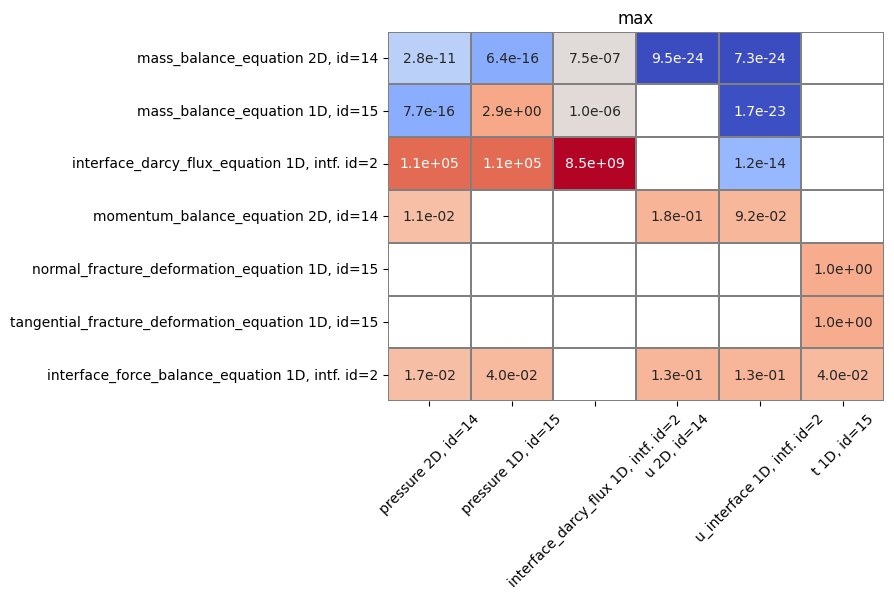

In [29]:
model.assemble_linear_system()
diagnostics = model.run_diagnostics(
    grouping=None, additional_handlers={"shape": lambda x, a, b: x.shape[0]}
)
model.plot_diagnostics(diagnostics, key="max")

In [16]:
from collections import defaultdict

right_eq_order = [
    "momentum_balance_equation 2D, id=0",
    "mass_balance_equation 2D, id=0",
    "normal_fracture_deformation_equation 1D, id=1",
    "tangential_fracture_deformation_equation 1D, id=1",
    "mass_balance_equation 1D, id=1",
    "interface_force_balance_equation 1D, intf. id=0",
    "interface_darcy_flux_equation 1D, intf. id=0",
]
right_var_order = [
    "u 2D, id=0",
    "pressure 2D, id=0",
    "t 1D, id=1",
    "pressure 1D, id=1",
    "u_interface 1D, intf. id=0",
    "interface_darcy_flux 1D, intf. id=0",
]

right_eq_map = []
right_var_map = []

for eq_name in right_eq_order:
    for ind, data in diagnostics.items():
        if data["equation_printed_name"] == eq_name:
            right_eq_map.append(ind[0])
            break
for var_name in right_var_order:
    for ind, data in diagnostics.items():
        if data["variable_printed_name"] == var_name:
            right_var_map.append(ind[1])
            break

new_diagnostics = defaultdict(dict)

for i, row in enumerate(right_eq_map):
    for j, col in enumerate(right_var_map):
        new_diagnostics[i, j] = diagnostics[row, col].copy()

new_diagnostics = dict(sorted(new_diagnostics.items(), key=lambda x: x[0]))

model.plot_diagnostics(new_diagnostics, key="max")

diagnostics = new_diagnostics

NameError: name 'diagnostics' is not defined

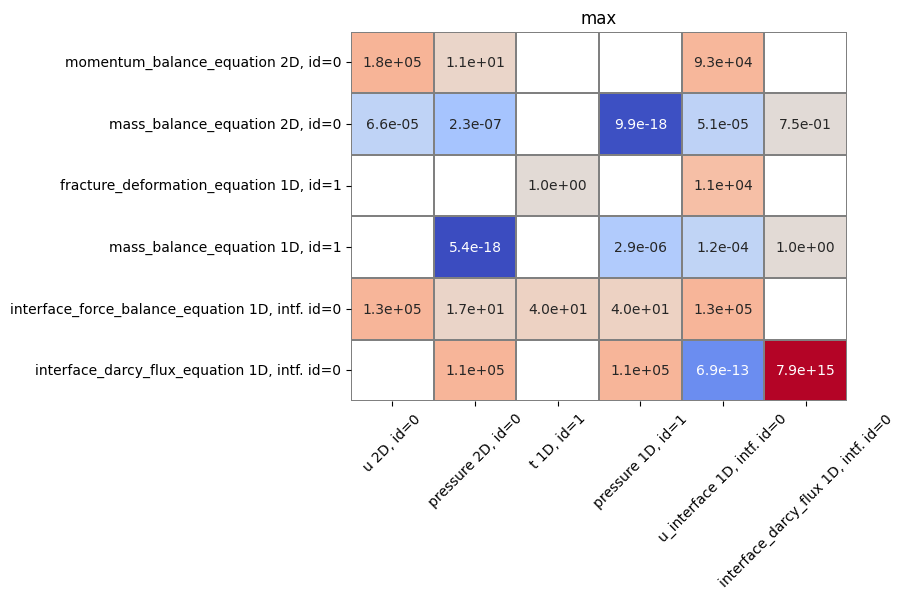

In [ ]:
from collections import defaultdict

eq_to = "normal_fracture_deformation_equation 1D, id=1"
eq_from = "tangential_fracture_deformation_equation 1D, id=1"
eq_name = "fracture_deformation_equation 1D, id=1"

row_from = None
row_to = None
row_max = -1
col_max = -1

for ind, data in diagnostics.items():
    row_max = max(ind[0], row_max)
    col_max = max(ind[1], col_max)
    if data["equation_printed_name"] == eq_to:
        row_to = ind[0]
    if data["equation_printed_name"] == eq_from:
        row_from = ind[0]

assert row_from is not None and row_to is not None
if row_from > row_to:
    row_from, row_to = row_to, row_from

row_max -= 1

new_diagnostics = defaultdict(dict)

for ind, data in diagnostics.items():
    if ind[0] > row_to:
        new_diagnostics[ind[0] - 1, ind[1]] = data.copy()
    else:
        new_diagnostics[ind] = data.copy()

    if ind[0] == row_to:
        old = diagnostics[row_to, ind[1]]["block_dofs_row"]
        new = data["block_dofs_row"]
        new_diagnostics[row_to, ind[1]]["block_dofs_row"] = np.concatenate([old, new])

        old = diagnostics[row_to, ind[1]]["block_dofs_col"]
        new = data["block_dofs_col"]
        new_diagnostics[row_to, ind[1]]["block_dofs_col"] = np.concatenate([old, new])


for (i, j), data in new_diagnostics.items():
    if data["equation_printed_name"] == eq_to:
        data["equation_printed_name"] = eq_name


model.plot_diagnostics(new_diagnostics, key="max")

In [ ]:
full_mat, full_rhs = model.linear_system

matrices = np.zeros((6, 6), dtype=object)
for i in range(6):
    for j in range(6):
        col = new_diagnostics[i, j]["block_dofs_col"]
        row = new_diagnostics[i, j]["block_dofs_row"]
        C, R = np.meshgrid(col, row, indexing="ij", sparse=True)
        A = full_mat[C, R]
        A.sort_indices()
        matrices[i, j] = A

/tmp/ipykernel_619/728721777.py:15: RuntimeWarning: invalid value encountered in divide
  dom = diag / offdiag_sum


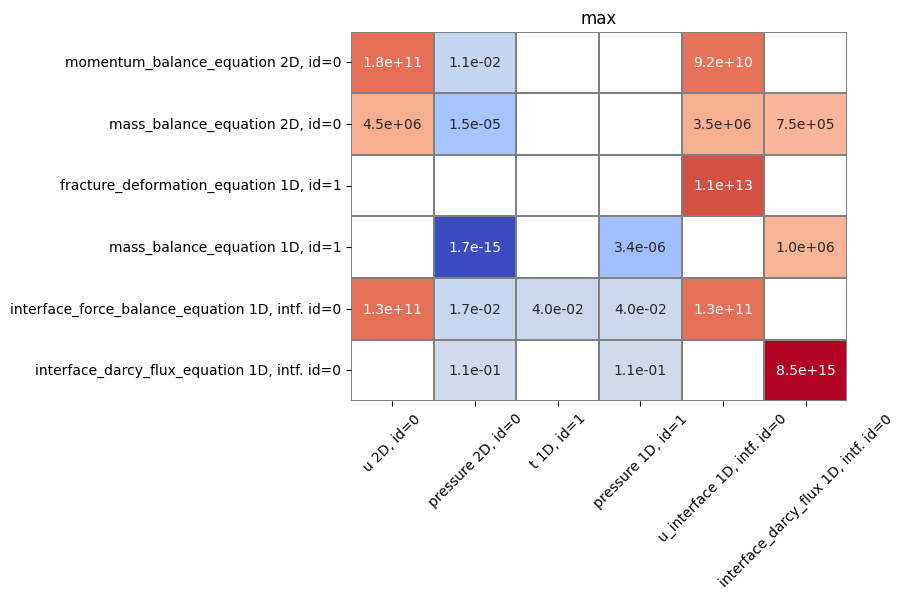

In [ ]:
from scipy.sparse import eye


def diag_dom(mat):
    if mat.shape[0] != mat.shape[1]:
        return 0
    diag = mat.diagonal()
    diag_mat = eye(*mat.shape)
    diag_mat.data[:] = diag
    offdiag = mat - diag_mat
    offdiag_sum = np.array(abs(offdiag).sum(axis=1)).ravel()

    offdiag_sum[offdiag_sum == 0] == 1
    diag = abs(diag)
    dom = diag / offdiag_sum
    return dom.min()


for (i, j), data in new_diagnostics.items():
    data["diag_dom"] = diag_dom(matrices[i, j])
    # data['num_diags'] = matrices[i, j].todia().data.shape[0]

model.plot_diagnostics(new_diagnostics, key="max")

In [16]:
import sympy as sp
import numpy as np


def make_Jsym(commutative=False):
    return [
        [sp.Symbol(f"J_{i}{j}", commutative=commutative) for j in range(6)]
        for i in range(6)
    ]


def make_J(commutative=False):
    Jsym = make_Jsym(commutative=commutative)
    J = sp.Matrix(Jsym)
    J[0, 1] = 0
    J[0, 4] = 0
    J[1, 0] = 0
    J[1, 3] = 0
    J[1, 4] = 0
    J[2, 3] = 0
    J[2, 4] = 0
    J[3, 1] = 0
    J[3, 2] = 0
    J[3, 4] = 0
    J[4, 0] = 0
    J[4, 1] = 0
    J[4, 2] = 0
    J[4, 3] = 0
    J[5, 2] = 0
    return J


def make_J_nofrac(commutative=False):
    J = [
        [sp.Symbol(f"J_{i}{j}", commutative=commutative) for j in [0, 3]]
        for i in [0, 3]
    ]
    J = sp.Matrix(J)
    J_force_inv = J[1:, 1:].inv(method="BLOCK")
    return J[:1, :1] - J[:1, 1:] @ J_force_inv @ J[1:, :1]


def make_schur(commutative=False):
    J = make_J(commutative=commutative)

    J_force_inv = J[3:, 3:].inv(method="BLOCK")

    return J[:3, :3] - J[:3, 3:] @ J_force_inv @ J[3:, :3]


def make_sym(commutative):
    Jsym = make_Jsym(commutative=commutative)
    Schur = make_schur(commutative=commutative)

    vals = np.arange(36)

    return sp.lambdify(np.array(Jsym).ravel(), Schur)(*vals)


expected = make_sym(True)
result = make_sym(False)

result - expected

array([[8.88178420e-16, 1.33226763e-15, 0.00000000e+00],
       [1.77635684e-15, 3.55271368e-15, 0.00000000e+00],
       [0.00000000e+00, 7.10542736e-15, 0.00000000e+00]])

In [19]:
make_J_nofrac(False)

Matrix([[J_00 - J_03*J_33**(-1)*J_30]])

In [20]:
S = make_schur(False)
S[0, 0]

J_00 - ((J_03*(1 + J_53*J_33**(-1)*(-J_53*J_33**(-1)*J_35 - J_54*J_44**(-1)*J_45 + J_55)**(-1)*J_35)*J_33**(-1) - J_05*J_53*J_33**(-1)*(-J_53*J_33**(-1)*J_35 - J_54*J_44**(-1)*J_45 + J_55)**(-1))*J_30 + (-J_03*(-J_53*J_33**(-1)*J_35 - J_54*J_44**(-1)*J_45 + J_55)**(-1)*J_35*J_33**(-1) + J_05*(-J_53*J_33**(-1)*J_35 - J_54*J_44**(-1)*J_45 + J_55)**(-1))*J_50)

In [54]:
from sympy.vector import Del

t, p, u = sp.symbols("t p u")
u = sp.Function(u)(t)
p = sp.Function(p)(t)
nabla, alpha, m = sp.symbols(r"\nabla \alpha m")

K, nu, rho_f, g = sp.symbols(r"K \nu \rho_f g")
v = -K / nu * (nabla * p - rho_f * g)
# nabla = sp.physics.units.Quantity(r'$\nabla$')
# m = sp.physics.units.Quantity('m')
# alpha = sp.physics.units.Quantity(r'$\alpha$')
F0 = 1 / m * p.diff(t) + alpha * (nabla * u).diff(t) + v
F0

-K*(\nabla*p(t) - \rho_f*g)/\nu + \alpha*\nabla*Derivative(u(t), t) + Derivative(p(t), t)/m

In [2]:
from frac_poromech_small import make_model
import porepy as pp
from matplotlib import pyplot as plt


small = make_model()
small.prepare_simulation()
pp.run_time_dependent_model(small, {"prepare_simulation": False, "progressbars": True})

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


time loop:   0%|          | 0/1 [00:00<?, ?it/s]

Newton loop:   0%|          | 0/10 [00:00<?, ?it/s]

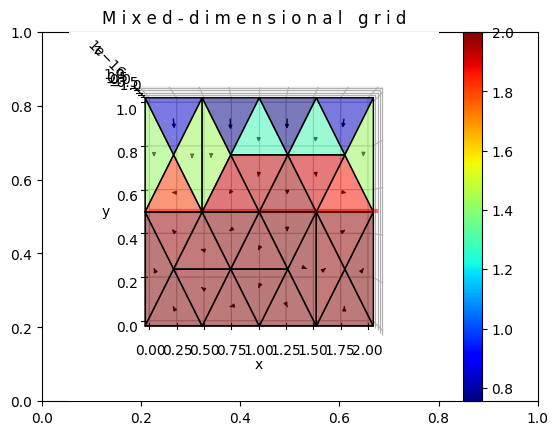

In [4]:
pp.plot_grid(
    small.mdg,
    cell_value=small.pressure_variable,
    vector_value=small.displacement_variable,
    fracturewidth_1d=3,
    # plot_2d=True,
    rgb=[0.5, 0.5, 1],
    alpha=0.5,
    # info='ncfo',
)

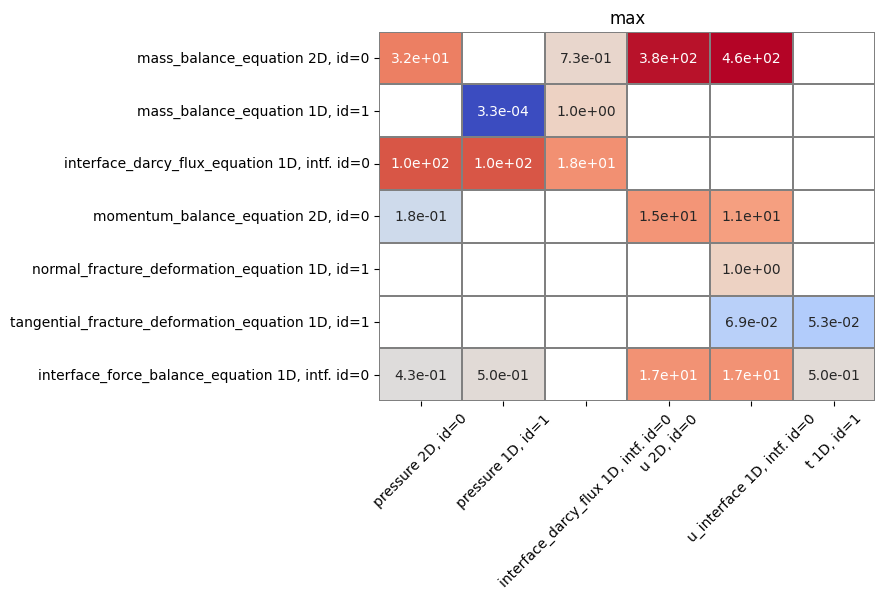

In [5]:
small.assemble_linear_system()
diagnostics = small.run_diagnostics()
small.plot_diagnostics(diagnostics, key="max")

In [6]:
import numpy as np
from scipy.sparse import bmat
from mat_utils import *

In [7]:
small.sticking_sliding_open()

(array([ True,  True,  True, False]),
 array([False, False, False,  True]),
 array([False, False, False, False]))

Text(0.5, 1.0, 'sticking')

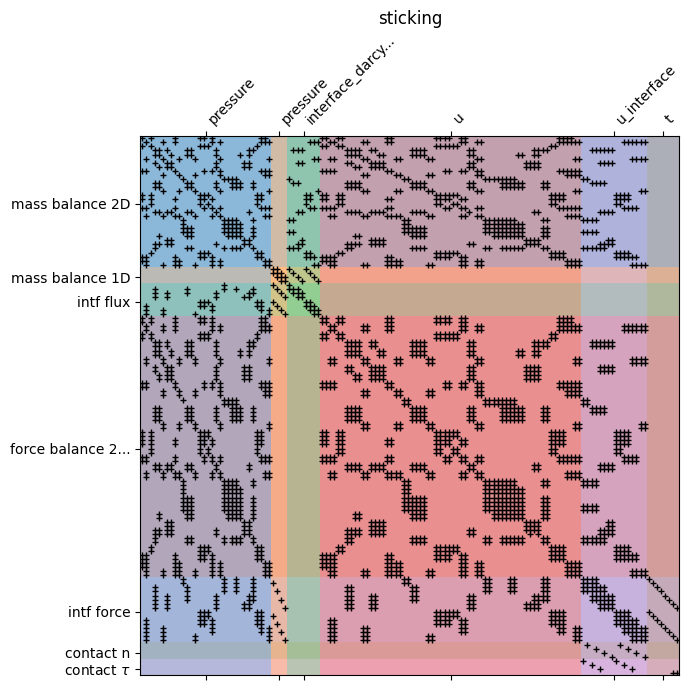

In [8]:
mass_balance_2d = small.mass_balance_equation(small.mdg.subdomains(dim=2))
mass_balance_2d.set_name("mass balance 2D")
mass_balance_1d = small.mass_balance_equation(small.mdg.subdomains(dim=1))
mass_balance_1d.set_name("mass balance 1D")
intf_flow = small.interface_flux_equation(small.mdg.interfaces())
intf_flow.set_name("intf flux")
force_balance = small.momentum_balance_equation(small.mdg.subdomains(dim=2))
force_balance.set_name("force balance 2D")
norm_cont_eq = small.normal_fracture_deformation_equation(small.mdg.subdomains(dim=1))
norm_cont_eq.set_name("contact n")
tang_cont_eq = small.tangential_fracture_deformation_equation(
    small.mdg.subdomains(dim=1)
)
tang_cont_eq.set_name(r"contact $\tau$")
intf_force = small.interface_force_balance_equation(small.mdg.interfaces())
intf_force.set_name("intf force")

plt.figure(figsize=(7, 7))
plot_jacobian(
    small,
    [
        mass_balance_2d,
        mass_balance_1d,
        intf_flow,
        force_balance,
        intf_force,
        norm_cont_eq,
        tang_cont_eq,
    ]
)
plt.title("sticking")

mat.shape=(132, 132)
A.shape=(32, 32)
B.shape=(32, 64)
C.shape=(64, 32)
D.shape=(64, 64)
E.shape=(32, 36)
F.shape=(64, 36)
G.shape=(36, 32)
H.shape=(36, 64)
K.shape=(36, 36)


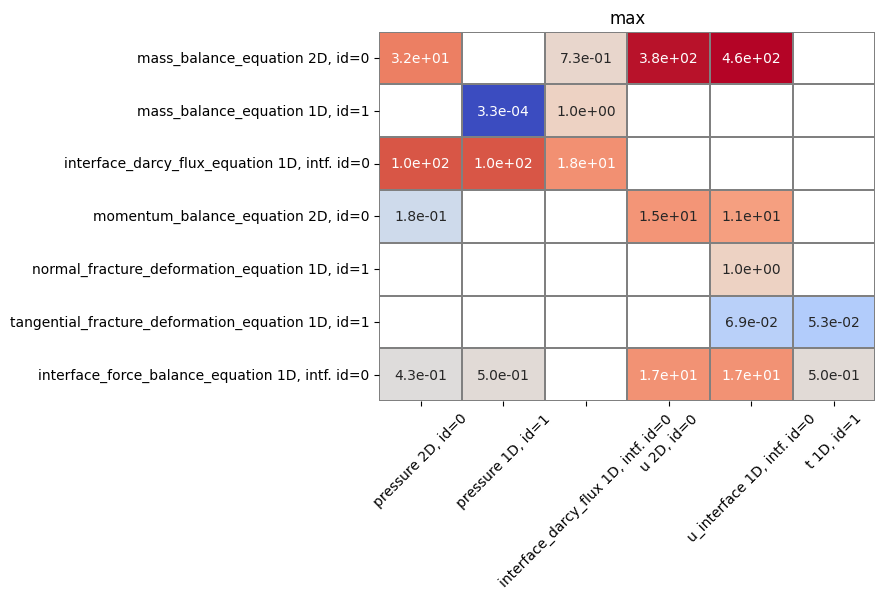

In [9]:
import itertools

small.assemble_linear_system()
diagnostics = small.run_diagnostics()
small.plot_diagnostics(diagnostics, key="max")

mat, rhs = small.linear_system


def get_submat(row_ids, col_ids):
    rows, cols = [], []

    try:
        row_ids[0]
    except TypeError:
        row_ids = [row_ids]
    try:
        col_ids[0]
    except TypeError:
        col_ids = [col_ids]

    for i, j in itertools.product(row_ids, col_ids):
        d = diagnostics[i, j]
        rows.append(d["block_dofs_row"])
        cols.append(d["block_dofs_col"])

    rows = np.unique(np.concatenate(rows))
    cols = np.unique(np.concatenate(cols))

    rows, cols = np.meshgrid(rows, cols, sparse=True, copy=True, indexing="ij")
    return mat[rows, cols]


A = get_submat(0, 0)
B = get_submat(0, 3)
C = get_submat(3, 0)
D = get_submat(3, 3)
E = get_submat(0, [1, 2, 4, 5])
F = get_submat(3, [1, 2, 4, 5])
G = get_submat([1, 2, 4, 5, 6], 0)
H = get_submat([1, 2, 4, 5, 6], 3)
K = get_submat([1, 2, 4, 5, 6], [1, 2, 4, 5])

print(f"{mat.shape=}")
print(f"{A.shape=}")
print(f"{B.shape=}")
print(f"{C.shape=}")
print(f"{D.shape=}")
print(f"{E.shape=}")
print(f"{F.shape=}")
print(f"{G.shape=}")
print(f"{H.shape=}")
print(f"{K.shape=}")

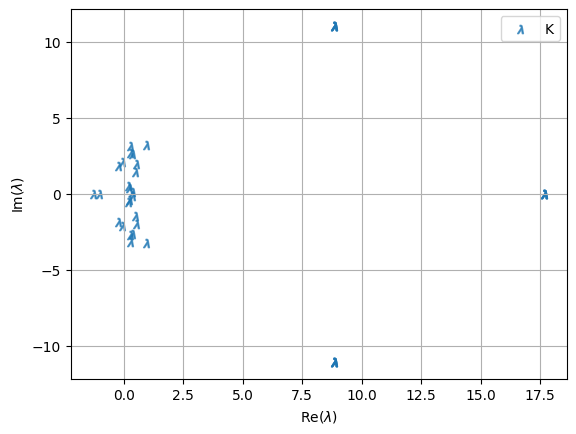

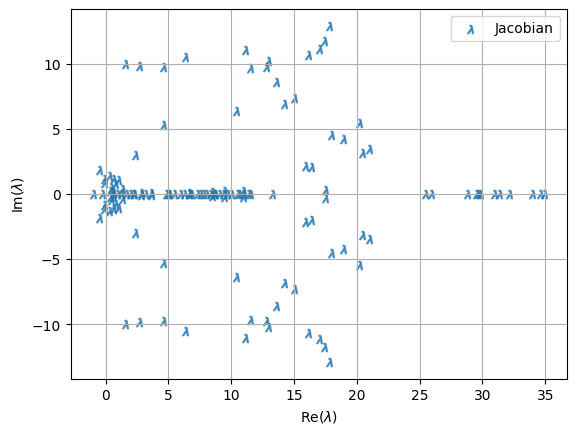

In [10]:
plot_eigs(K, label="K")
plt.show()
plot_eigs(mat, label="Jacobian")

In [11]:
Km1 = inv(K)
E_Km1_G = E @ Km1 @ G
F_Km1_G = F @ Km1 @ G
E_Km1_H = E @ Km1 @ H
F_Km1_H = F @ Km1 @ H

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


/home/porepy/simulations/mat_utils.py:64: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


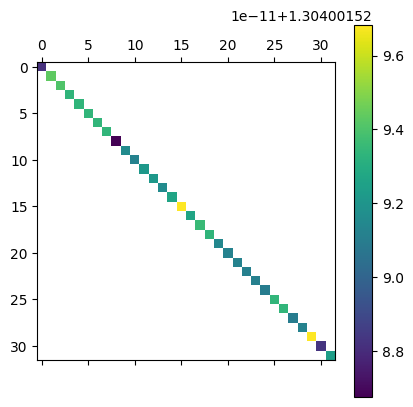

In [13]:
# Dm1 = scipy.sparse.linalg.inv(D)
# B_Dm1_C = B @ Dm1 @ C
B_Dm1_C = -get_fixed_stress_stabilization(0.6)
# B_Dm1_C *= 0

plot_mat(B_Dm1_C, log=True)

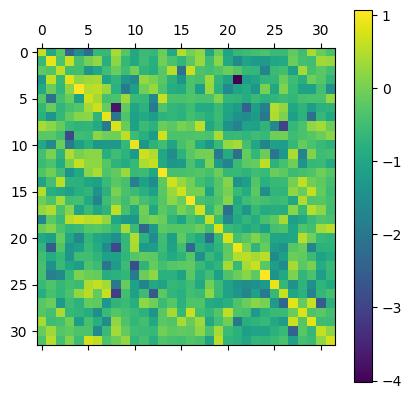

In [14]:
Bp = B - E_Km1_H
Ap = A - E_Km1_G
Cp = C - F_Km1_G
Dp = D - F_Km1_H

Dpm1 = scipy.sparse.linalg.inv(Dp)
Bp_Dpm1_Cp = Bp @ Dpm1 @ Cp
plot_mat(Bp_Dpm1_Cp, log=True)

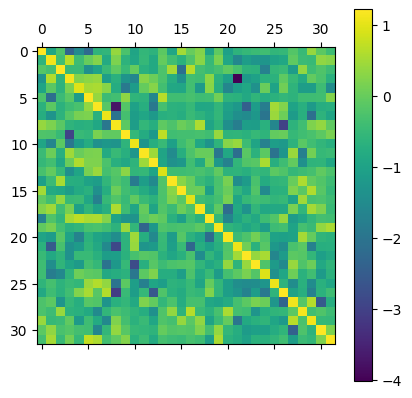

In [15]:
plot_mat(Bp_Dpm1_Cp - B_Dm1_C, log=True)

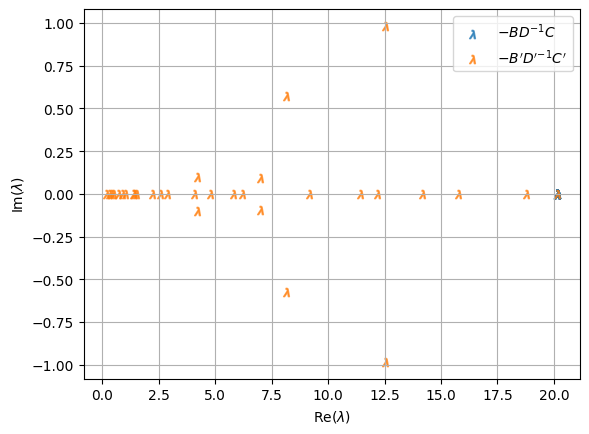

In [16]:
plot_eigs(-B_Dm1_C, label="$-B D^{-1} C$")
plot_eigs(-Bp_Dpm1_Cp, label="$-B' D'^{-1} C'$")

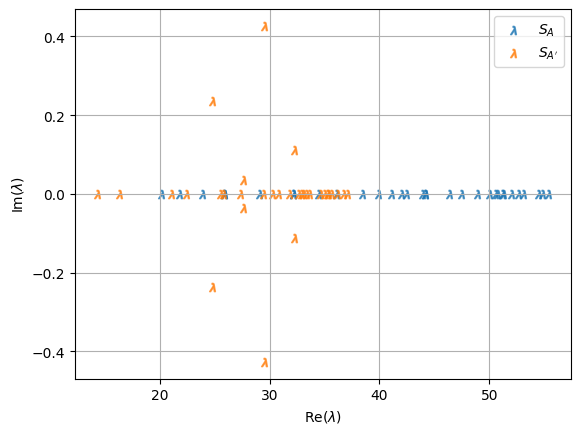

In [17]:
S_A = A - B_Dm1_C
S_Ap = Ap - Bp_Dpm1_Cp

plot_eigs(S_A, label="$S_A$")
plot_eigs(S_Ap, label="$S_{A'}$")

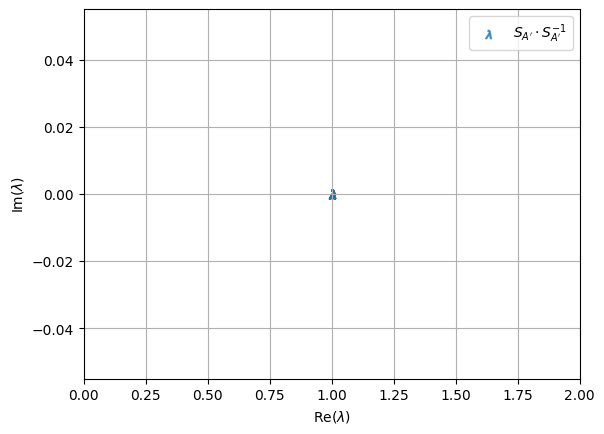

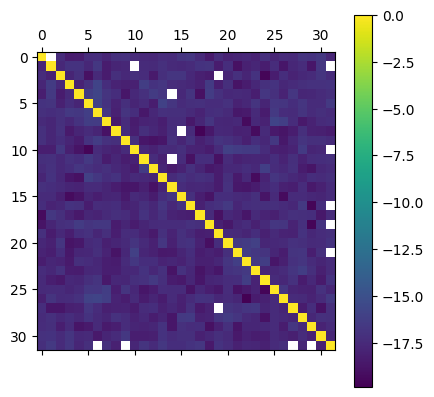

In [18]:
S_Ap_inv = scipy.sparse.linalg.inv(S_Ap)
plot_eigs(S_Ap_inv @ S_Ap, label="$S_{A'} \cdot S_{A'}^{-1}$")
plt.xlim(0, 2)

plot_mat(S_Ap_inv @ S_Ap)

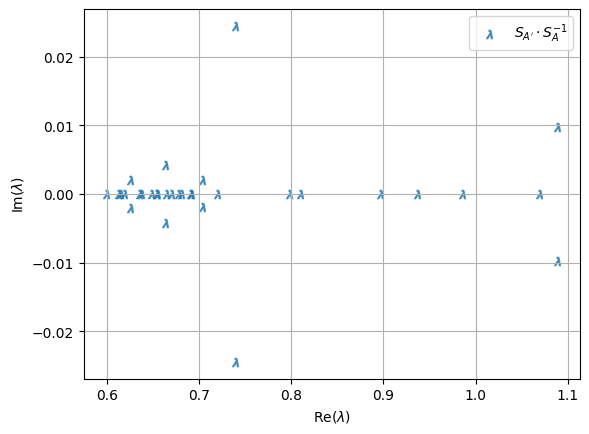

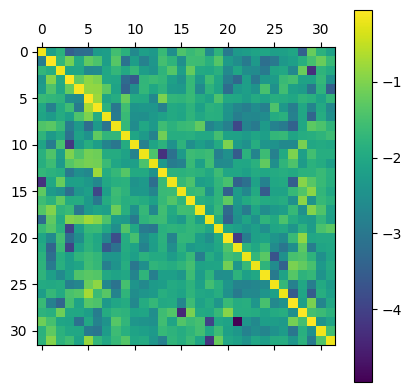

In [19]:
S_A_inv = scipy.sparse.linalg.inv(S_A)
plot_eigs(S_Ap @ S_A_inv, label="$S_{A'} \cdot S_{A}^{-1}$")

plot_mat(S_A_inv @ S_Ap)

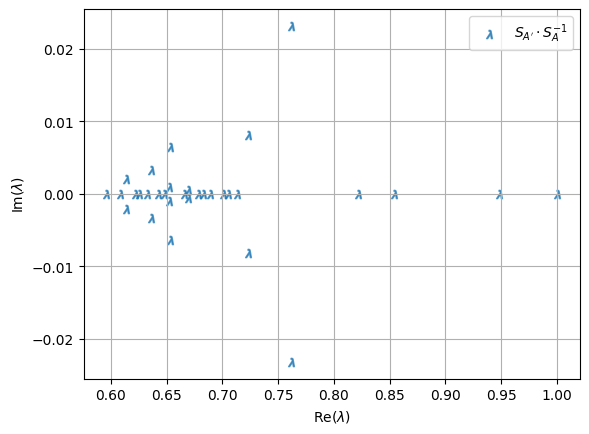

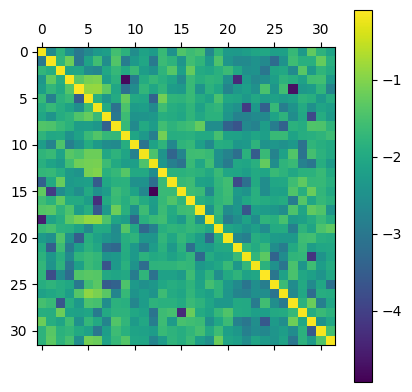

In [20]:
S_Ap_fs = Ap - B_Dm1_C
S_Ap_fs_inv = scipy.sparse.linalg.inv(S_Ap_fs)
plot_eigs(S_Ap_fs_inv @ S_Ap, label="$S_{A'} \cdot S_{A}^{-1}$")

plot_mat(S_Ap_fs_inv @ S_Ap)

In [21]:
import scipy.sparse


def make_omega_inv(S_inv):
    I_A = scipy.sparse.eye(A.shape[0])
    I_D = scipy.sparse.eye(D.shape[0])

    Dp_m1 = scipy.sparse.linalg.inv(Dp)

    Lp_m1 = scipy.sparse.bmat(
        [
            [I_D, None],
            [-Bp @ Dp_m1, I_A],
        ]
    )

    Up_m1 = scipy.sparse.bmat(
        [
            [I_D, -Dp_m1 @ Cp],
            [None, I_A],
        ]
    )

    Dp_m1 = scipy.sparse.bmat(
        [
            [Dp_m1, None],
            [None, S_inv],
        ]
    )

    # plot_mat(Lp_m1)
    # plot_mat(Up_m1)
    # plot_mat(Dp_m1)
    Omega_p_m1 = Up_m1 @ Dp_m1 @ Lp_m1
    return Omega_p_m1

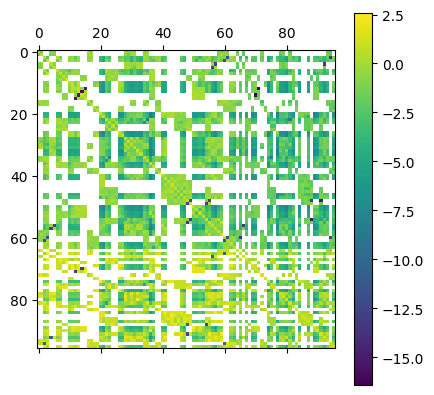

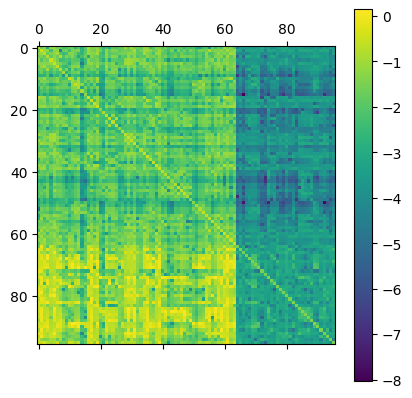

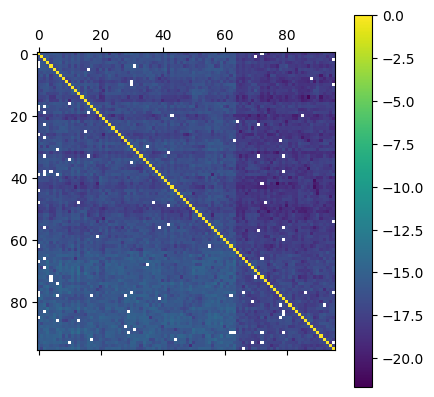

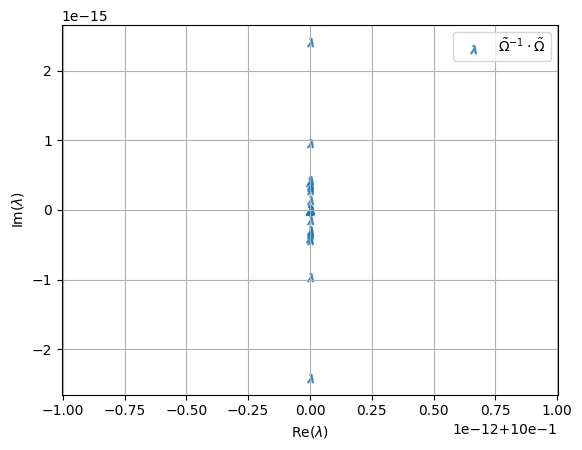

In [22]:
Omega_p = scipy.sparse.bmat(
    [
        [Dp, Cp],
        [Bp, Ap],
    ]
)

Omega_p_inv_exact = make_omega_inv(S_Ap_inv)

plot_mat(Omega_p)
plot_mat(Omega_p_inv_exact)
plot_mat(Omega_p_inv_exact @ Omega_p)
plt.show()
plot_eigs(Omega_p_inv_exact @ Omega_p, r"$\tilde{\Omega}^{-1} \cdot \tilde{\Omega}$")

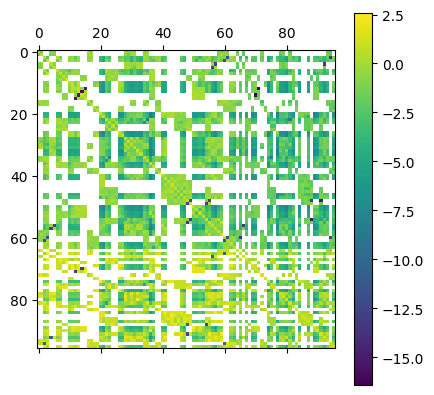

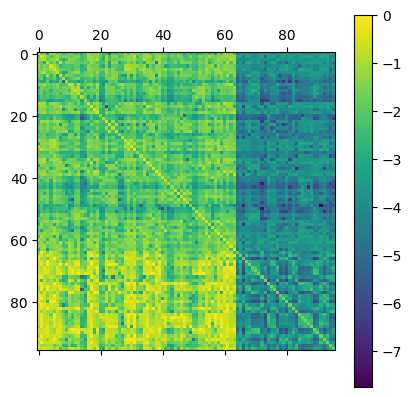

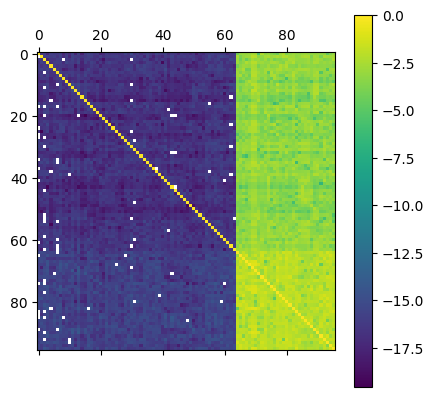

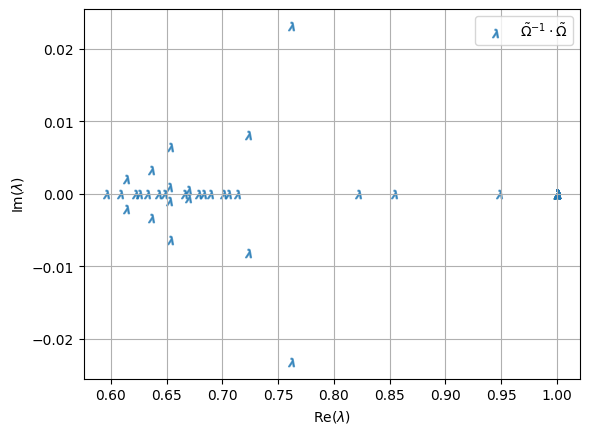

In [23]:
Omega_p_inv_fs = make_omega_inv(S_Ap_fs_inv)

plot_mat(Omega_p)
plot_mat(Omega_p_inv_fs)
plot_mat(Omega_p_inv_fs @ Omega_p)
plt.show()
plot_eigs(Omega_p_inv_fs @ Omega_p, r"$\tilde{\Omega}^{-1} \cdot \tilde{\Omega}$")

In [25]:
block_matrix = []
for i in range(len(eq_dofs)):
    block_row = []
    for j in range(len(var_dofs)):
        block_row.append(slice_matrix(mat, eq_dofs, var_dofs, i, j))
    block_matrix.append(block_row)

block_matrix = np.array(block_matrix)

A = block_matrix[0, 0]
B = block_matrix[0, 3]
C = block_matrix[3, 0]
D = block_matrix[3, 3]
E = concatenate_blocks(block_matrix, [0], [1, 2, 4, 5])
F = concatenate_blocks(block_matrix, [3], [1, 2, 4, 5])
G = concatenate_blocks(block_matrix, [1, 2, 4, 5, 6], [0])
H = concatenate_blocks(block_matrix, [1, 2, 4, 5, 6], [3])
K = concatenate_blocks(block_matrix, [1, 2, 4, 5, 6], [1, 2, 4, 5])
Omega = concatenate_blocks(block_matrix, [3, 0], [3, 0])
Phi = concatenate_blocks(block_matrix, [1, 2, 4, 5, 6], [3, 0])

D_inv_exact = scipy.sparse.linalg.inv(D)
S_A_exact = A - B @ D_inv_exact @ C

assert (Omega - scipy.sparse.bmat([[D, C], [B, A]])).data.size == 0

In [28]:
A_test = csr_matrix(np.array([[1, 0], [0, 1]]))
B_test = csr_matrix(np.array([[1, 0, 0], [0, 1, 0]])) * 0.5
C_test = csr_matrix(np.array([[1, 0], [0, 1], [0, 0]])) * 0.5
D_test = csr_matrix(
    np.array(
        [
            [1, 0, 0],
            [0, 1, 0],
            [0, 0, 1],
        ]
    )
)
Omega_test = scipy.sparse.bmat([[D_test, C_test], [B_test, A_test]])

Omega_test_inv = inv(Omega_test)
S_test = A_test - B_test @ inv(D_test) @ C_test
Omega_test_inv_op = OmegaInv(D_inv=inv(D_test), S_A_inv=inv(S_test), B=B_test, C=C_test)

ones = np.ones(5)

expected = Omega_test_inv.dot(ones)
result = Omega_test_inv_op.dot(ones)

abs(expected - result).max()

1.1102230246251565e-16

In [29]:
S_A_inv_exact = inv(S_A_exact)
Omega_inv_exact = inv(Omega)
Omega_inv_exact_op = OmegaInv(
    D_inv=D_inv_exact,
    S_A_inv=S_A_inv_exact,
    B=B,
    C=C,
)

In [30]:
ones = np.ones(Omega_inv_exact_op.shape[0])
expected = Omega_inv_exact.dot(ones)
result = Omega_inv_exact_op.dot(ones)
abs(result - expected).max()

2947548552915664.0

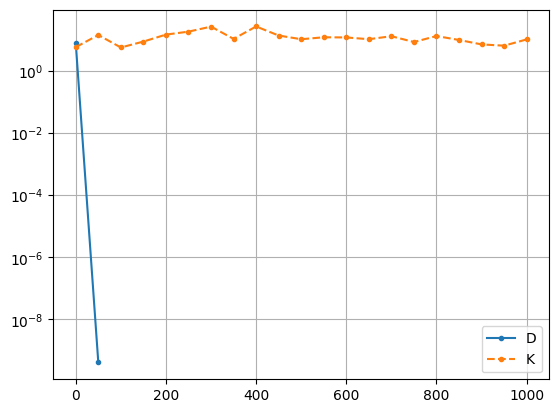

In [31]:



# solve(Omega, label='noprec')
# solve(Omega, Omega_inv_exact, label='exact prec')
# solve(Omega, Omega_inv_exact_op, label="exact op prec")
solve(D, label='D')
solve(K, label='K')
plt.legend()